# Background

* Dataset: https://github.com/PathologyDataScience/BCSS
* Paper: https://academic.oup.com/bioinformatics/article/35/18/3461/5307750

# Setup: Importing the libraries and the dataset

In [ ]:
!pip -q install datasets==2.3.2
!pip -q install huggingface-hub==0.8.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.26.0.dev0 requires huggingface-hub<1.0,>=0.10.0, but you have huggingface-hub 0.8.1 which is incompatible.


In [ ]:
!pip install git+https://github.com/huggingface/transformers -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from datasets import load_dataset, load_metric, Dataset, Image
from huggingface_hub import cached_download, hf_hub_url
from tensorflow.keras.optimizers import Adam

from transformers import (
    DefaultDataCollator,
    SegformerFeatureExtractor,
    SegformerImageProcessor,
    TFSegformerForSemanticSegmentation,
    create_optimizer,
)
from transformers.keras_callbacks import KerasMetricCallback

import urllib
from urllib import request

import matplotlib.image as mpimg
import pandas as pd

import cv2
import os
import sklearn

In [ ]:
# verify GPU access
!nvidia-smi

Wed Jan  4 20:48:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
TEST_RATIO = 0.2
SEED = 123
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 2
MAX_DATASET_SIZE = 152

## Load Images from Drive

In [ ]:
IMAGES_DIRECTORY = '/content/rgbs_colorNormalized';
MASKS_DIRECTORY = '/content/masks'

In [ ]:
!unzip gdrive/MyDrive/PRS_Project/masks-20221122T203004Z-001.zip 
!unzip gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-001.zip
!unzip gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-002.zip
!unzip gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-003.zip

Archive:  gdrive/MyDrive/PRS_Project/masks-20221122T203004Z-001.zip
replace masks/TCGA-A7-A26F-DX1_xmin72969_ymin11489_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-001.zip
replace rgbs_colorNormalized/TCGA-OL-A5RW-DX1_xmin5772_ymin6839_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-002.zip
replace rgbs_colorNormalized/TCGA-A7-A0DA-DX1_xmin43731_ymin18175_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-003.zip
replace rgbs_colorNormalized/TCGA-OL-A5D7-DX1_xmin114443_ymin22490_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Build Huggingface Dataset

In [ ]:
sample_names_list = os.listdir(IMAGES_DIRECTORY)
sample_names_list[:2]

['TCGA-A2-A04Q-DX1_xmin20868_ymin17804_MPP-0.2500.png',
 'TCGA-OL-A97C-DX1_xmin68058_ymin32495_MPP-0.2500.png']

In [ ]:
def concat_list(prefix, string_list):
  return [prefix + string for string in string_list]

In [ ]:
image_names_list = concat_list(IMAGES_DIRECTORY + "/", sample_names_list)
image_names_list[:2]

['/content/rgbs_colorNormalized/TCGA-A2-A04Q-DX1_xmin20868_ymin17804_MPP-0.2500.png',
 '/content/rgbs_colorNormalized/TCGA-OL-A97C-DX1_xmin68058_ymin32495_MPP-0.2500.png']

In [ ]:
mask_names_list = concat_list(MASKS_DIRECTORY + "/", sample_names_list)
mask_names_list[:2]

['/content/masks/TCGA-A2-A04Q-DX1_xmin20868_ymin17804_MPP-0.2500.png',
 '/content/masks/TCGA-OL-A97C-DX1_xmin68058_ymin32495_MPP-0.2500.png']

In [ ]:
dataset = Dataset.from_dict({"pixel_values": image_names_list, "label": mask_names_list}).cast_column("pixel_values", Image()).cast_column("label", Image())

In [ ]:
dataset[0]

{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1816x1813 at 0x7F50CF3C7460>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1816x1813 at 0x7F50CF3C71F0>}

## Train Test Split

In [ ]:
dataset = dataset.train_test_split(test_size=TEST_RATIO)

In [ ]:
train_ds = dataset["train"]
test_ds = dataset["test"]

In [ ]:
train_ds[0]

## Loading the Class Definitions

In [ ]:
classes_df = pd.read_csv("gdrive/MyDrive/PRS_Project/gtruth_codes.csv")
classes_df

,label,GT_code
0,outside_roi,0
1,tumor,1
2,stroma,2
3,lymphocytic_infiltrate,3
4,necrosis_or_debris,4
5,glandular_secretions,5
6,blood,6
7,exclude,7
8,metaplasia_NOS,8
9,fat,9


In [ ]:
nr_classes = len(classes_df)

**Important**: The "outside_roi" class is "don't case", not "others", and should be assigned weight 0 in the model.

In [ ]:
id2label = {row[" GT_code"]: row["label"] for index, row in classes_df.iterrows()}
label2id = {row["label"]: row[" GT_code"] for index, row in classes_df.iterrows()}

In [ ]:
id2label

{0: 'outside_roi',
 1: 'tumor',
 2: 'stroma',
 3: 'lymphocytic_infiltrate',
 4: 'necrosis_or_debris',
 5: 'glandular_secretions',
 6: 'blood',
 7: 'exclude',
 8: 'metaplasia_NOS',
 9: 'fat',
 10: 'plasma_cells',
 11: 'other_immune_infiltrate',
 12: 'mucoid_material',
 13: 'normal_acinus_or_duct',
 14: 'lymphatics',
 15: 'undetermined',
 16: 'nerve',
 17: 'skin_adnexa',
 18: 'blood_vessel',
 19: 'angioinvasion',
 20: 'dcis',
 21: 'other'}

In [ ]:
label2id

{'outside_roi': 0,
 'tumor': 1,
 'stroma': 2,
 'lymphocytic_infiltrate': 3,
 'necrosis_or_debris': 4,
 'glandular_secretions': 5,
 'blood': 6,
 'exclude': 7,
 'metaplasia_NOS': 8,
 'fat': 9,
 'plasma_cells': 10,
 'other_immune_infiltrate': 11,
 'mucoid_material': 12,
 'normal_acinus_or_duct': 13,
 'lymphatics': 14,
 'undetermined': 15,
 'nerve': 16,
 'skin_adnexa': 17,
 'blood_vessel': 18,
 'angioinvasion': 19,
 'dcis': 20,
 'other': 21}

## Convert to Tensorflow compatible Dataset

In [ ]:
from transformers.models.segformer.image_processing_segformer import SegformerImageProcessor
feature_extractor = SegformerImageProcessor()

def transforms(image):
    image = tf.keras.utils.img_to_array(image)
    image = image.transpose((2, 0, 1))
    return image


def preprocess(example_batch):
    images = [transforms(x.convert("RGB")) for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = feature_extractor(images, labels) # crop to 512x512, and normalize
    return inputs

In [ ]:
train_ds.set_transform(preprocess)
test_ds.set_transform(preprocess)

In [ ]:
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 120
})

In [ ]:
train_ds[0]

{'pixel_values': array([[[-1.1931673 , -1.141793  , -1.0904187 , ..., -0.7307989 ,
          -1.1931673 , -1.7240347 ],
         [-0.95342064, -1.141793  , -1.073294  , ..., -0.26843056,
          -0.8335474 , -1.0390445 ],
         [-0.88492167, -1.004795  , -0.91917115, ...,  0.43368444,
          -0.7307989 , -0.8677969 ],
         ...,
         [ 0.03981499, -0.7650484 , -0.06293353, ..., -0.42255333,
          -0.31980482, -0.33692956],
         [ 0.33093593, -0.19993155, -0.14855729, ..., -0.59380084,
          -0.37117907, -0.57667613],
         [ 0.2624369 ,  0.2624369 , -0.5081771 , ..., -0.5253019 ,
          -0.5424266 , -0.69654936]],
 
        [[ 0.5903362 ,  0.7303922 ,  0.62535024, ...,  0.62535024,
           0.2226892 , -0.495098  ],
         [ 0.95798326,  0.62535024,  0.5903362 , ...,  1.0980393 ,
           0.78291327,  0.3627452 ],
         [ 1.1505603 ,  0.74789923,  0.74789923, ...,  1.5182073 ,
           0.81792724,  0.3802522 ],
         ...,
         [ 1.2380

In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

train_set = train_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

test_set = test_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

In [ ]:
# Investigate a single batch.
batch = next(iter(train_set))
batch["pixel_values"].shape, batch["labels"].shape

(TensorShape([2, 3, 512, 512]), TensorShape([2, 512, 512]))

# Exploratory Data Analysis

## Sample Images in the drive folders

In [ ]:
def plot_image_and_mask(image_name):
  plt.figure(figsize=(20, 8))
  plt.suptitle("Image: " + image_name)

  plt.subplot(1, 2, 1)
  mask = mpimg.imread(MASKS_DIRECTORY + image_name)
  plt.imshow(mask)
  plt.title("Mask")
  
  plt.subplot(1, 2, 2)
  image = mpimg.imread(IMAGES_DIRECTORY + image_name)
  plt.imshow(image)
  plt.title("Image")

  plt.show()

  print("Image shape", image.shape, "Mask shape: ", mask.shape)

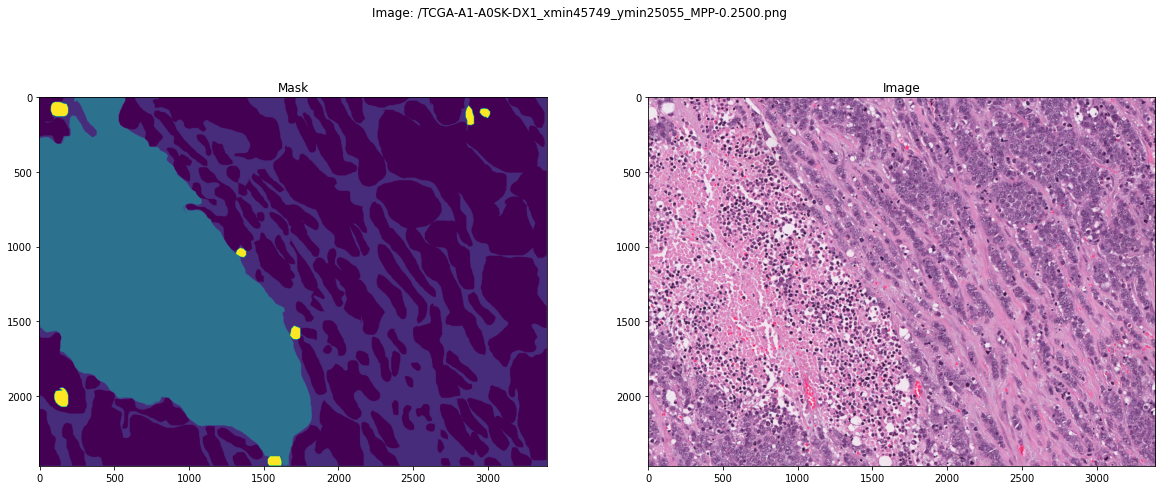

Image shape (2467, 3394, 3) Mask shape:  (2467, 3394)


In [ ]:
plot_image_and_mask('/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.2500.png')

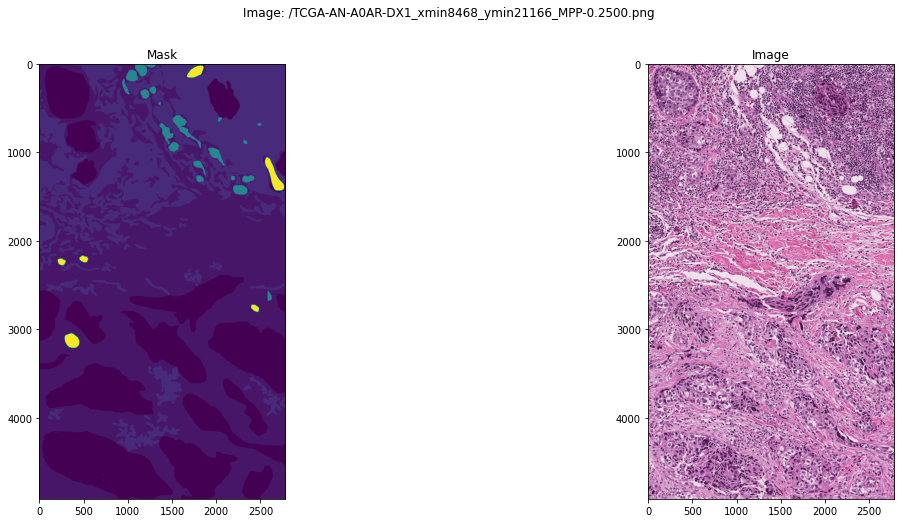

Image shape (4917, 2782, 3) Mask shape:  (4917, 2782)


In [ ]:
plot_image_and_mask('/TCGA-AN-A0AR-DX1_xmin8468_ymin21166_MPP-0.2500.png')

## Sample images in the dataset (after resizing)

In [ ]:
def display_tumors(display_list):
  # source: https://www.tensorflow.org/tutorials/images/segmentation
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Tumors']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i].numpy().astype("uint8"), data_format='channels_first'))
    plt.axis('off')
  plt.show()

Sample Batch in the Training Dataset


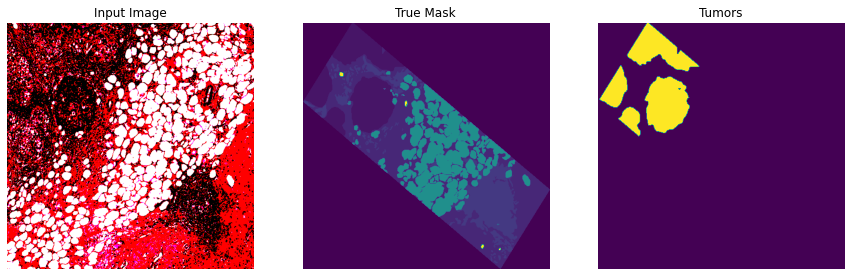

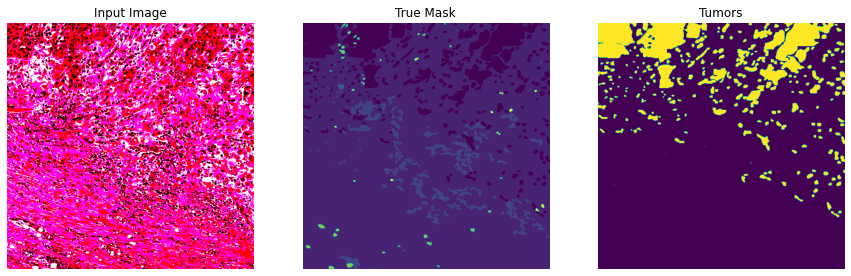

In [ ]:
print("Sample Batch in the Training Dataset")

batch = next(iter(train_set))
for image, mask in zip(batch["pixel_values"], batch["labels"]):
  mask = tf.reshape(mask, [1, mask.shape[0], mask.shape[1]])
  display_tumors([image, mask, tf.cast(mask == 1, tf.int32)])

# Finetuning a Segformer

## Define metrics

In [ ]:
metric = load_metric("mean_iou")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits are of shape (batch_size, num_labels, height, width), so
    # we first transpose them to (batch_size, height, width, num_labels)
    logits = tf.transpose(logits, perm=[0, 2, 3, 1])
    # scale the logits to the size of the label
    logits_resized = tf.image.resize(
        logits,
        size=tf.shape(labels)[1:],
        method="bilinear",
    )
    # compute the prediction labels and compute the metric
    pred_labels = tf.argmax(logits_resized, axis=-1)
    metrics = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=nr_classes,
        ignore_index=-1,
        reduce_labels=True, #ignore the 0 class
    )
    return {"val_" + k: v for k, v in metrics.items()}


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=test_set,
    batch_size=BATCH_SIZE,
    label_cols=["labels"],
)

## Load pretrained Segformer

In [ ]:
model_checkpoint = "nvidia/mit-b0"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=nr_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the 

In [ ]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMainL  multiple                 3319392   
 ayer)                                                           
                                                                 
 decode_head (TFSegformerDec  multiple                 400918    
 odeHead)                                                        
                                                                 
Total params: 3,720,310
Trainable params: 3,719,798
Non-trainable params: 512
_________________________________________________________________


## Finetune the model

In [ ]:
NR_EPOCHS = 10

In [ ]:
checkpoint_path = "gdrive/MyDrive/PRS_Project/checkpoints/segformer/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=60)

In [ ]:
hiostory = model.fit(
    train_set,
    validation_data=test_set,
    callbacks=[cp_callback, metric_callback],
    epochs=NR_EPOCHS,
    batch_size = BATCH_SIZE
)

Epoch 1/10
59/60 [============================>.] - ETA: 2s - loss: 1.9693
Epoch 1: saving model to gdrive/MyDrive/PRS_Project/checkpoints/segformer/cp-0001.ckpt
60/60 [==============================] - 314s 5s/step - loss: 1.9611 - val_loss: 1.5206 - val_mean_iou: 0.0068 - val_mean_accuracy: 0.0228 - val_overall_accuracy: 0.0937 - val_per_category_iou: nan - val_per_category_accuracy: nan


/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


Epoch 2/10
59/60 [============================>.] - ETA: 2s - loss: 1.4243
Epoch 2: saving model to gdrive/MyDrive/PRS_Project/checkpoints/segformer/cp-0002.ckpt
60/60 [==============================] - 286s 5s/step - loss: 1.4325 - val_loss: 1.8717 - val_mean_iou: 0.0107 - val_mean_accuracy: 0.0261 - val_overall_accuracy: 0.1315 - val_per_category_iou: nan - val_per_category_accuracy: nan
Epoch 3/10
59/60 [============================>.] - ETA: 2s - loss: 1.3845
Epoch 3: saving model to gdrive/MyDrive/PRS_Project/checkpoints/segformer/cp-0003.ckpt
60/60 [==============================] - 388s 6s/step - loss: 1.3818 - val_loss: 1.4310 - val_mean_iou: 0.0096 - val_mean_accuracy: 0.0435 - val_overall_accuracy: 0.0950 - val_per_category_iou: nan - val_per_category_accuracy: nan
Epoch 4/10
59/60 [============================>.] - ETA: 2s - loss: 1.3546
Epoch 4: saving model to gdrive/MyDrive/PRS_Project/checkpoints/segformer/cp-0004.ckpt
60/60 [==============================] - 290s 5s/ste

## Inference

In [ ]:
def display_inference_result(display_list):
  # source: https://www.tensorflow.org/tutorials/images/segmentation
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i].astype("uint8"), data_format='channels_first'))
    plt.axis('off')
  plt.show()

In [ ]:
test_image = test_ds[0]["pixel_values"]
test_gt = test_ds[0]["labels"]
test_image.shape

(3, 512, 512)

In [ ]:
inputs = feature_extractor(images=test_image, return_tensors="tf")
outputs = model(**inputs)

In [ ]:
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# Transpose to have the shape (batch_size, height/4, width/4, num_labels)
logits = tf.transpose(logits, [0, 2, 3, 1])

# First, rescale logits to original image size
upsampled_logits = tf.image.resize(
    logits,
    (test_image.shape[2], test_image.shape[1])
)

# Second, apply argmax on the class dimension
pred_seg = tf.math.argmax(upsampled_logits, axis=-1)[0]
pred_seg = pred_seg.numpy()
print(pred_seg.shape)

(512, 512)


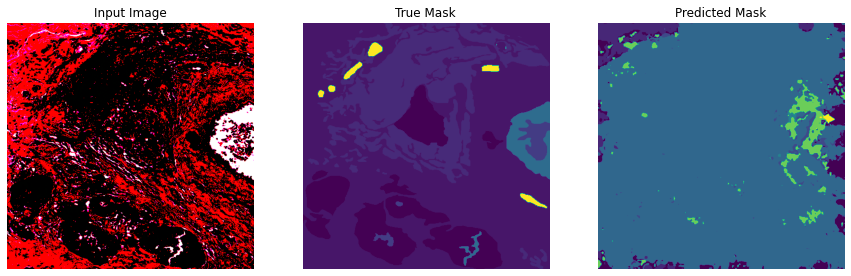

In [ ]:
display_inference_result([test_image, test_gt.reshape(1, test_gt.shape[0], test_gt.shape[1]), pred_seg.reshape(1, pred_seg.shape[0], pred_seg.shape[1])])